<a href="https://colab.research.google.com/github/aisha13dikko-sudo/AISD-poverty-Kaduna/blob/master/Nigeria_tabular_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade xgboost


In [ ]:
# setup and imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb
import torch


In [ ]:
# Load Nigeria LSMS data
cons = pd.read_csv("totcons_final.csv")
hh   = pd.read_csv("nga_householdgeovars_y4.csv")

print(cons.columns)
print(hh.columns)



Index(['hhid', 'zone', 'sector', 'ea', 'hhsize', 'wt_wave4', 'popw',
       'food_own1', 'food_purch1', 'food_own2', 'food_purch2', 'food_own3',
       'food_purch3', 'food_own4', 'food_purch4', 'food_own5', 'food_purch5',
       'food_own6', 'food_purch6', 'food_own7', 'food_purch7', 'food_own8',
       'food_purch8', 'food_own9', 'food_purch9', 'food_own10', 'food_purch10',
       'food_own11', 'food_purch11', 'food_own12', 'food_purch12',
       'food_own13', 'food_purch13', 'food_own14', 'food_purch14',
       'food_own15', 'food_purch15', 'food_own16', 'food_purch16',
       'food_own17', 'food_purch17', 'food_own18', 'food_purch18',
       'food_own19', 'food_purch19', 'food_meals20', 'nonfood21', 'nonfood22',
       'nonfood23', 'nonfood24', 'nonfood25', 'nonfood26', 'nonfood27',
       'nonfood28', 'nonfood29', 'edu29', 'edu30', 'health31', 'health32',
       'rent33', 'reg_def_mean', 'totcons_pc', 'totcons_adj',
       'totcons_adj_norm'],
      dtype='object')
Index(['hhid', 

In [ ]:

df = cons.merge(hh, on="hhid", how="inner")
print(df.shape)
df.head()


(4976, 100)


,hhid,zone,sector,ea,hhsize,wt_wave4,popw,food_own1,food_purch1,food_own2,...,h2018_tot,h2018_wetQ,h2018_wetQstart,qstartavg,ndvi_avg,ndvi_max,h2018_ndvi_avg,h2018_ndvi_max,lat_dd_mod,lon_dd_mod
0,10001,4,1,670,6,15279.640625,91677.843750,0.0,3041.666667,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
1,10002,4,1,670,5,15279.640625,76398.203125,0.0,4171.428516,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
2,10003,4,1,670,6,15279.640625,91677.843750,0.0,3804.035807,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
3,10004,4,1,670,4,15279.640625,61118.562500,0.0,9125.000000,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536
4,10005,4,1,670,6,15279.640625,91677.843750,0.0,0.000000,0.0,...,2279,1088,13,26,0.347,0.462,0.463,0.54,5.535456,7.531536


In [ ]:
import numpy as np

print(df.shape)
print(df.columns[:15])

(4976, 100)
Index(['hhid', 'zone', 'sector', 'ea', 'hhsize', 'wt_wave4', 'popw',
       'food_own1', 'food_purch1', 'food_own2', 'food_purch2', 'food_own3',
       'food_purch3', 'food_own4', 'food_purch4'],
      dtype='object')


In [ ]:
# features and log-target

# Keep only rows with positive consumption
df_model = df[df["totcons_adj"] > 0].copy()

# Log-transform target (this stabilises the model)
y = np.log(df_model["totcons_adj"])

# Drop direct leakage versions of the target
drop_cols = ["totcons_adj", "totcons_pc", "totcons_adj_norm"]

# All numeric predictors except dropped columns
feature_cols = [c for c in df_model.columns
                if c not in drop_cols]

X = df_model[feature_cols].select_dtypes(include=[np.number]).copy()

X.shape, y.shape


((4976, 97), (4976,))

In [ ]:
# Train/validation/test split + scaling
# 80% train+val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# From train+val, take 25% as val  (so 60/20/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)

# Standardise features for the model
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

X_train_s.shape, X_val_s.shape, X_test_s.shape


((2985, 97), (995, 97), (996, 97))

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

print("xgboost version:", xgb.__version__)

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

print("Model type:", type(xgb_model))


xgboost version: 3.1.2
Model type: <class 'xgboost.sklearn.XGBRegressor'>


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import callback as xgb_callback # Import callback module

# Define the model once
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    eval_metric="rmse", # Moved here as per modern XGBoost API for early stopping
    random_state=42,
    n_jobs=-1,
)



In [ ]:
xgb_model.fit(
    X_train_s,
    y_train,
    eval_set=[(X_train_s, y_train), (X_val_s, y_val)],
    verbose=True
)

[0]	validation_0-rmse:0.62550	validation_1-rmse:0.67450
[1]	validation_0-rmse:0.60316	validation_1-rmse:0.65242
[2]	validation_0-rmse:0.58118	validation_1-rmse:0.63068
[3]	validation_0-rmse:0.56040	validation_1-rmse:0.61064
[4]	validation_0-rmse:0.54149	validation_1-rmse:0.59259
[5]	validation_0-rmse:0.52246	validation_1-rmse:0.57445
[6]	validation_0-rmse:0.50463	validation_1-rmse:0.55727
[7]	validation_0-rmse:0.48775	validation_1-rmse:0.54104
[8]	validation_0-rmse:0.47109	validation_1-rmse:0.52468
[9]	validation_0-rmse:0.45524	validation_1-rmse:0.50925
[10]	validation_0-rmse:0.44116	validation_1-rmse:0.49540
[11]	validation_0-rmse:0.42653	validation_1-rmse:0.48095
[12]	validation_0-rmse:0.41292	validation_1-rmse:0.46798
[13]	validation_0-rmse:0.40050	validation_1-rmse:0.45592
[14]	validation_0-rmse:0.38825	validation_1-rmse:0.44415
[15]	validation_0-rmse:0.37639	validation_1-rmse:0.43304
[16]	validation_0-rmse:0.36523	validation_1-rmse:0.42242
[17]	validation_0-rmse:0.35491	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# Evaluate Model (Train and validation)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict
y_train_pred = xgb_model.predict(X_train_s)
y_val_pred   = xgb_model.predict(X_val_s)

def print_metrics(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f}")
    print(f"{name} MAE : {mae:.4f}")
    print(f"{name} R²   : {r2:.4f}")
    print("-" * 30)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_val,   y_val_pred,   "Validation")


Train RMSE: 0.0268
Train MAE : 0.0202
Train R²   : 0.9983
------------------------------
Validation RMSE: 0.1568
Validation MAE : 0.0984
Validation R²   : 0.9497
------------------------------


In [ ]:
# Convert RMSE back to original scale
y_raw = df["totcons_adj"].values  # or whatever your original column is called
print("Log(totcons_adj) mean & std:", y_raw.mean(), y_raw.std())


Log(totcons_adj) mean & std: 215598.35869965516 185796.44544956493


In [ ]:
y.mean(), y.std()

(np.float64(12.044648091004738), 0.6656599929476931)

In [ ]:
y_std = y.std()
rmse_real_log_space = val_rmse_std * y_std
rmse_real_log_space

np.float64(0.10438897264049765)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) RMSE in *standardised log* space
mse = mean_squared_error(y_val, y_val_pred)
val_rmse_std = np.sqrt(mse)

# 2) Convert to *log(cons)* space
log_std = y.std()
rmse_log = val_rmse_std * log_std

# 3) Convert to original Naira scale using mean of log(consumption)
mean_log = y.mean()
rmse_naira = np.exp(mean_log + rmse_log) - np.exp(mean_log)

print(f"Validation RMSE (standardised log): {val_rmse_std:.4f}")
print(f"Validation RMSE (log(cons)):       {rmse_log:.4f}")
print(f"Approx Validation RMSE (Naira):    ₦{rmse_naira:,.0f}")

Validation RMSE (standardised log): 0.1568
Validation RMSE (log(cons)):       0.1044
Approx Validation RMSE (Naira):    ₦18,726


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# If you have a list/Index of feature names:
feature_names = X.columns  # or whatever you used before scaling

importances = xgb_model.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

imp_df.head(15)


,feature,importance
50,nonfood25,0.192459
51,nonfood26,0.107488
45,food_meals20,0.075311
20,food_purch7,0.065237
47,nonfood22,0.058242
59,rent33,0.055306
10,food_purch2,0.041330
26,food_purch10,0.026325
68,af_bio_12,0.024169
57,health31,0.022400


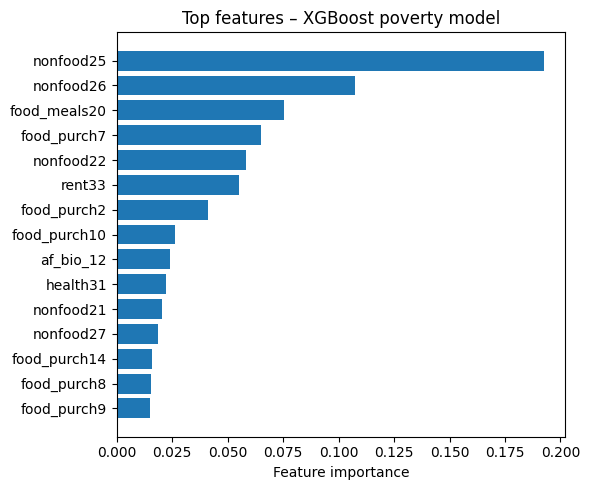

In [ ]:
# plot curve
top_k = 15
top = imp_df.head(top_k)

plt.figure(figsize=(6, 5))
plt.barh(top["feature"], top["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Top features – XGBoost poverty model")
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on Validation and test (log-space + original space)
def evaluate_split(model, X_s, y_true, name=""):
    y_pred = model.predict(X_s)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"{name} (log-space)")
    print(f"  MSE : {mse:.3f}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE : {mae:.3f}")
    print(f"  R^2 : {r2:.3f}")

    # Back-transform to original consumption space
    y_true_lin = np.exp(y_true)
    y_pred_lin = np.exp(y_pred)

    mse_lin  = mean_squared_error(y_true_lin, y_pred_lin)
    rmse_lin = np.sqrt(mse_lin)
    mae_lin  = mean_absolute_error(y_true_lin, y_pred_lin)
    r2_lin   = r2_score(y_true_lin, y_pred_lin)

    print(f"{name} (original consumption space)")
    print(f"  MSE : {mse_lin:.3f}")
    print(f"  RMSE: {rmse_lin:.3f}")
    print(f"  MAE : {mae_lin:.3f}")
    print(f"  R^2 : {r2_lin:.3f}")
    print("-" * 40)

    return (y_true, y_pred, y_true_lin, y_pred_lin)

val_log, val_pred_log, _, _   = evaluate_split(xgb_model, X_val_s,  y_val,  name="Validation")
test_log, test_pred_log, test_lin, test_pred_lin = evaluate_split(xgb_model, X_test_s, y_test, name="Test")


Validation (log-space)
  MSE : 0.025
  RMSE: 0.157
  MAE : 0.098
  R^2 : 0.950
Validation (original consumption space)
  MSE : 11435973992.249
  RMSE: 106939.113
  MAE : 27350.714
  R^2 : 0.735
----------------------------------------
Test (log-space)
  MSE : 0.024
  RMSE: 0.154
  MAE : 0.098
  R^2 : 0.948
Test (original consumption space)
  MSE : 4628480285.103
  RMSE: 68032.935
  MAE : 25742.309
  R^2 : 0.863
----------------------------------------


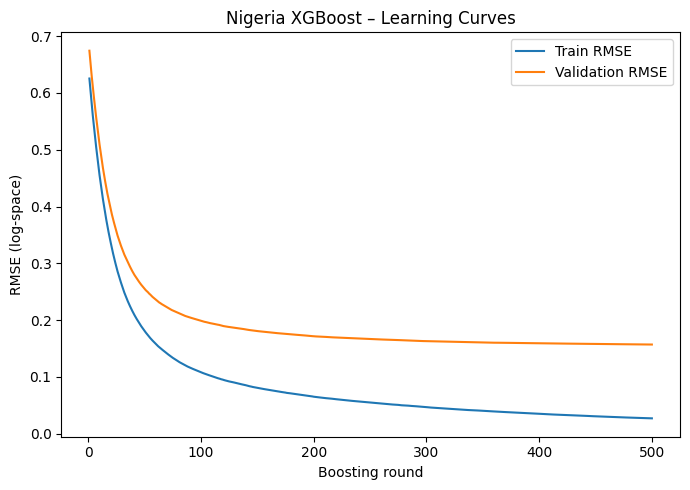

In [ ]:
# learning curve plot (RSME over boosting rounds)
train_rmse = xgb_model.evals_result_["validation_0"]["rmse"]
val_rmse   = xgb_model.evals_result_["validation_1"]["rmse"]
epochs     = range(1, len(train_rmse) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_rmse, label="Train RMSE")
plt.plot(epochs, val_rmse, label="Validation RMSE")
plt.xlabel("Boosting round")
plt.ylabel("RMSE (log-space)")
plt.title("Nigeria XGBoost – Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("nigeria_xgb_learning_curves.png", dpi=300)
plt.show()

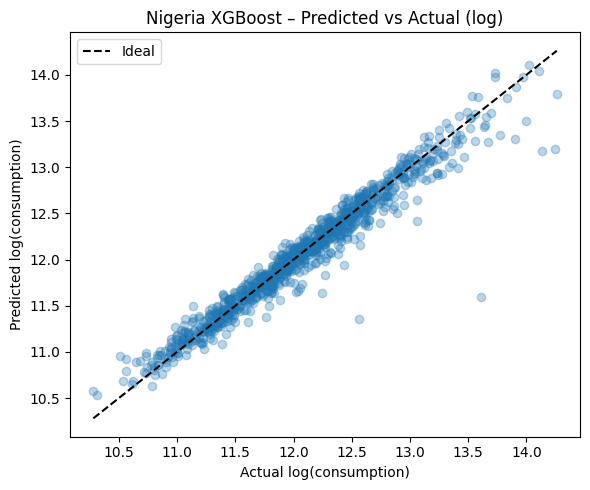

In [ ]:
# predicted vs Actual (log consumption) **for poster**
plt.figure(figsize=(6,5))
plt.scatter(test_log, test_pred_log, alpha=0.3)
line_min = min(test_log.min(), test_pred_log.min())
line_max = max(test_log.max(), test_pred_log.max())
plt.plot([line_min, line_max], [line_min, line_max], "k--", label="Ideal")
plt.xlabel("Actual log(consumption)")
plt.ylabel("Predicted log(consumption)")
plt.title("Nigeria XGBoost – Predicted vs Actual (log)")
plt.legend()
plt.tight_layout()
plt.savefig("nigeria_xgb_pred_vs_actual_log.png", dpi=300)
plt.show()


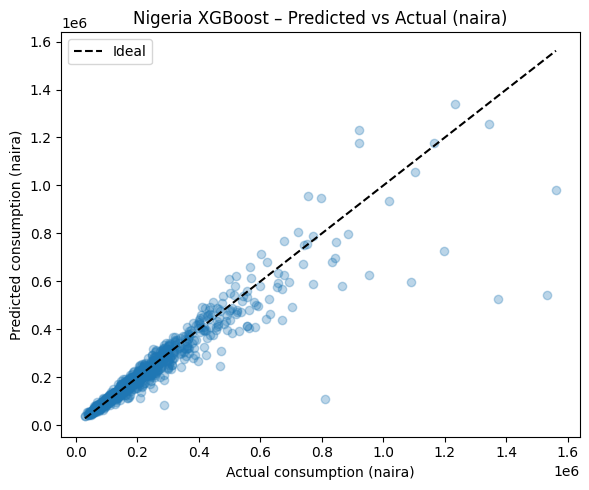

In [ ]:
# predicted vs Actual in original naira space
plt.figure(figsize=(6,5))
plt.scatter(test_lin, test_pred_lin, alpha=0.3)
line_min = min(test_lin.min(), test_pred_lin.min())
line_max = max(test_lin.max(), test_pred_lin.max())
plt.plot([line_min, line_max], [line_min, line_max], "k--", label="Ideal")
plt.xlabel("Actual consumption (naira)")
plt.ylabel("Predicted consumption (naira)")
plt.title("Nigeria XGBoost – Predicted vs Actual (naira)")
plt.legend()
plt.tight_layout()
plt.savefig("nigeria_xgb_pred_vs_actual_naira.png", dpi=300)
plt.show()
